In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

### R Code 11.1

In [5]:
df = pd.read_csv('./data/chimpanzees.csv', sep=';')
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1


- `pulled_left:` Outcome ${0, 1}$ - indicator if the animal pulled the left-hand lever.


- `prosoc_left:` Predict ${0, 1}$ - Indicator if left-hand lever was(1) or not(0) the prosocial options.


- `condition:` Predict ${0, 1}$ - Indicator if there is a partner (1) or not (0) in the end table. 

### R Code 11.2

In [6]:
df['treatment'] = 1 + df['prosoc_left'] + 2 * df['condition']
df.head()

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left,treatment
0,1,NaN,0,1,2,0,1,0,1
1,1,NaN,0,1,4,0,0,1,1
2,1,NaN,0,1,6,1,0,0,2
3,1,NaN,0,1,8,0,1,0,1
4,1,NaN,0,1,10,1,1,1,2


- treatment= $1$: prosoc_left = $0$ and contition= $0$: Two food items on **right** and **no partner**.


- treatment= $2$: prosoc_left = $1$ and contition= $0$: Two food items on **left** and **no partner**.


- treatment= $3$: prosoc_left = $0$ and contition= $1$: Two food items on **right** and **has partner**.


- treatment= $4$: prosoc_left = $1$ and contition= $1$: Two food items on **left** and **has partner**.

### R Code 11.3

In [7]:
df.pivot_table(['prosoc_left', 'condition'], 'treatment', aggfunc='count', margins=True)

,condition,prosoc_left
treatment,,
1,126,126
2,126,126
3,126,126
4,126,126
All,504,504


In [8]:
def logit(p):
    return np.log(p) - np.log(1 - p)

def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim \mbox{to be determined} $$
$$ \beta_k \sim \mbox{to be determined} $$

**Entendimento:**:

- **Likelihood**:

    Para esse caso os dados da resposta, *outcome*, são do tipo binários $0$ ou $1$. A função de likelihood apropriada para esses caso é a $Bernoulli(p)$, ou no caso $Binomial(1, p)$.

    Como $p$ é uma probabilidade, está entre $0$ e $1$, usamos uma *função de ligação* para **transformar** os resultados dos preditores para a escala de probabilidade. Nesse caso a função que faz essa transformação é:

$$ logit(p) = log(\frac{p}{1-p}) $$


- **Parameter $\alpha$**:

    Na função de ligação o parâmetro $\alpha$ é na verdade definido no modelo como um vetor (*vector*). O que estamos modelando aqui é que existe um parâmetro $\alpha$ para cada chimpanzé, ou seja, para cada *actor*.
    
    $$ \alpha[1] := \mbox{ Para o chimpanzé } 1 $$
    
    $$ \alpha[2] := \mbox{ Para o chimpanzé } 2 $$    
     
    $$ \alpha[3] := \mbox{ Para o chimpanzé } 3 $$    
    
    $$ \alpha[4] := \mbox{ Para o chimpanzé } 4 $$    
    
    $$ \alpha[5] := \mbox{ Para o chimpanzé } 5 $$    
    
    $$ \alpha[6] := \mbox{ Para o chimpanzé } 6 $$    
    
    $$ \alpha[7] := \mbox{ Para o chimpanzé } 7 $$
    
    Cada um dos parâmetros $\alpha$ tem um priori $Normal(\mu_i, \sigma_i)$ e essas prioris são idênticas.
    
    O que estamos inferindo com cada um desses $\alpha$'s é a localização ($\mu_i$) de cada uma das prioris e seu desvio padrão ($\sigma_i$)
    
    
    
- **Parameter $\beta$**:

    O $\beta$ é a representação de um vetor de $\beta$'s que mapeiam cada um dos tratamentos:
    
    $$ \beta[1] := \mbox{ Para o tratamento } 1 $$
    
    $$ \beta[2] := \mbox{ Para o tratamento } 2 $$
    
    $$ \beta[3] := \mbox{ Para o tratamento } 3 $$
    
    $$ \beta[4] := \mbox{ Para o tratamento } 4 $$
    

    No experimento existe uma hipóstese a ser testada: **Os chimpanzés tendem a puxar mais a alavanca do lado pro-social quando tem um outro chimpanzé do outro lado da mesa**, o *partner*?
    
    Os $\alpha$'s são independentes entre eles, porém quando colocamos os $\beta$'s estamos medindo qual é a inteção conjunta dos chimpanzés em cada tratamento.
    
    A variável tratamento (*treatment*) é a construção de uma **variável sintética que indexa** o conjunto de duas variáveis *{prosoc_left, condition}*, isto é, a **interação** entre elas. Então temos que a variável $treatment = 1$ indica que o experimento foi realizado usando dois pratos com comida no lado direito e que não tinha parceiro.
    
    Portando $\beta_{treatment = 1}$ terá o valor do *efeito de todos os experimentos* que os chimpanzés fizeram nesse tipo de tratamento.  

### R Code 11.4

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha $$

$$ \alpha \sim Normal(0, \omega) $$


$\omega = 10$ to start

In [9]:
# Creating data list to model
data_list_partial = df[['pulled_left', 'actor']].to_dict('list')
data_list_partial['N'] = len(df)
data_list_partial['qty_chimpanzees'] = len(df.actor.unique())

data_list_partial.keys()

dict_keys(['pulled_left', 'actor', 'N', 'qty_chimpanzees'])

In [10]:
model_partial = """
    data {
        int N;
        int qty_chimpanzees;
        int pulled_left[N];
        int actor[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 10);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori_partial = stan.build(model_partial, data=data_list_partial)
samples_partial = posteriori_partial.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_13_9shfe/model_otww5cyi.stan', line 5, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_13_9shfe/model_otww5cyi.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   5% (400/8000)
Sampling:  11% (900/8000)
Sampling:  22% (1800/8000)
Sampling:  48% (3800/8000)
Sampling:  68% (5400/8000)
Sampling:  86% (6900/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8.4e-

In [11]:
az.summary(samples_partial, var_names=['alpha'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.340,0.240,-0.696,0.059,0.004,0.003,3916.0,2806.0,1.0
alpha[1],11.137,5.222,3.908,18.600,0.129,0.096,2060.0,1932.0,1.0
alpha[2],-0.638,0.249,-1.010,-0.226,0.004,0.003,3901.0,2362.0,1.0
alpha[3],-0.647,0.252,-1.023,-0.228,0.004,0.003,3489.0,2475.0,1.0
alpha[4],-0.335,0.241,-0.716,0.050,0.004,0.003,3527.0,2694.0,1.0
alpha[5],0.579,0.256,0.168,0.990,0.004,0.003,3559.0,2563.0,1.0
alpha[6],2.136,0.395,1.505,2.736,0.007,0.005,3309.0,2075.0,1.0


In [12]:
samples_partial = az.from_pystan(
    posterior_model=posteriori_partial,
    posterior=samples_partial,
    observed_data=['pulled_left', 'actor']
)

### R Code 11.5

In [13]:
# extract prior from quap
omega = 10
N = 1000

norm_prior = np.random.normal(0, omega, N)

### R Code 11.6

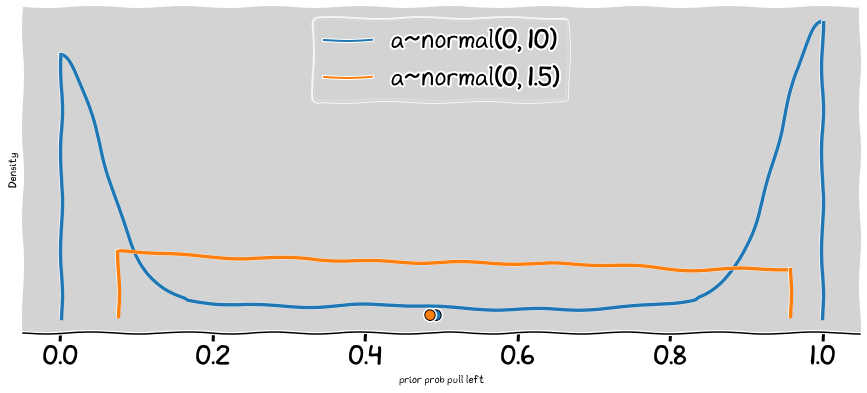

In [14]:
p = inv_logit(norm_prior)

omega = 1.5

better_p = inv_logit( np.random.normal(0, omega, N) ) 

az.plot_density([p, better_p],
                data_labels=['a~normal(0, 10)', 'a~normal(0, 1.5)'], 
                figsize=(15, 6))

plt.title('')
plt.xlabel('prior prob pull left')
plt.ylabel('Density')

plt.show()

In [15]:
model_partial_better = """
    data {
        int N;
        int qty_chimpanzees;
        int pulled_left[N];
        int actor[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori_partial_better = stan.build(model_partial_better, data=data_list_partial)
samples_partial_better = posteriori_partial_better.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_b4q0sg8x/model_rj4e4nsu.stan', line 5, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_b4q0sg8x/model_rj4e4nsu.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  10% (800/8000)
Sampling:  35% (2800/8000)
Sampling:  60% (4800/8000)
Sampling:  85% (6800/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 7e-05 seconds
  1000 transitions using 10 leapfrog steps p

In [16]:
az.summary(samples_partial_better, var_names=['alpha'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.329,0.234,-0.677,0.065,0.003,0.002,7192.0,3148.0,1.00
alpha[1],3.933,0.723,2.742,4.984,0.011,0.008,5538.0,2136.0,1.00
alpha[2],-0.620,0.241,-0.987,-0.212,0.003,0.002,6742.0,2859.0,1.00
alpha[3],-0.625,0.255,-1.047,-0.235,0.003,0.002,7290.0,2880.0,1.00
alpha[4],-0.328,0.235,-0.699,0.047,0.003,0.003,6804.0,2896.0,1.00
alpha[5],0.559,0.237,0.201,0.966,0.003,0.002,6854.0,3086.0,1.01
alpha[6],2.017,0.361,1.461,2.588,0.005,0.004,5420.0,2957.0,1.00


In [17]:
samples_parcial_better = az.from_pystan(
    posterior=samples_partial_better,
)

### R Code 11.7

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim Normal(0, 0.15) $$
$$ \beta_k \sim Normal(0, 10) $$

In [18]:
# quap code to get priori

### R Code 11.8

In [19]:
p = []

alpha = np.random.normal(0, 1.5, N)
betas = np.random.normal(0, 10, (4, N))

p = [inv_logit(alpha + beta) for beta in betas]

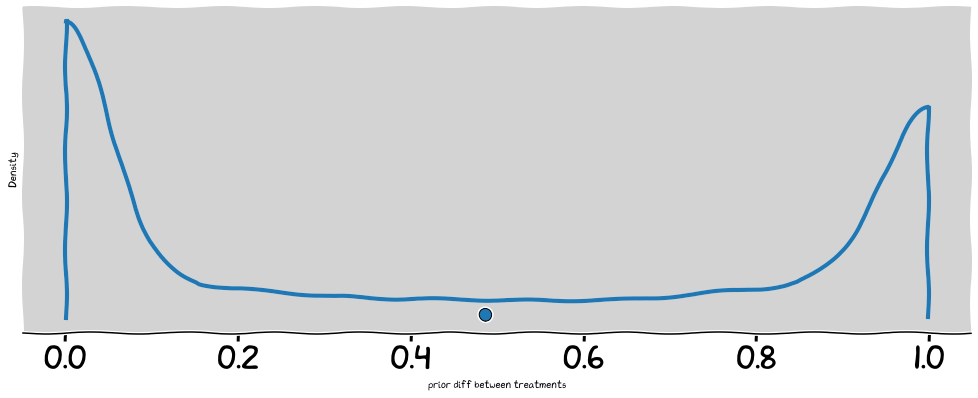

In [20]:
az.plot_density(np.absolute(p[0] - p[1]), figsize=(17, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

### R Code 11.9

$$ L_i \sim Binomial(1, p_i) $$

$$ logit(p_i) = \alpha_{ACTOR[i]} + \beta_{TREATEMENT[i]} $$

$$ \alpha_j \sim Normal(0, 0.15) $$
$$ \beta_k \sim Normal(0, 0.5) $$

In [21]:
better_p = []

alpha = np.random.normal(0, 1.5, N)
betas = np.random.normal(0, 0.5, (4, N))

better_p = [inv_logit(alpha + beta) for beta in betas]

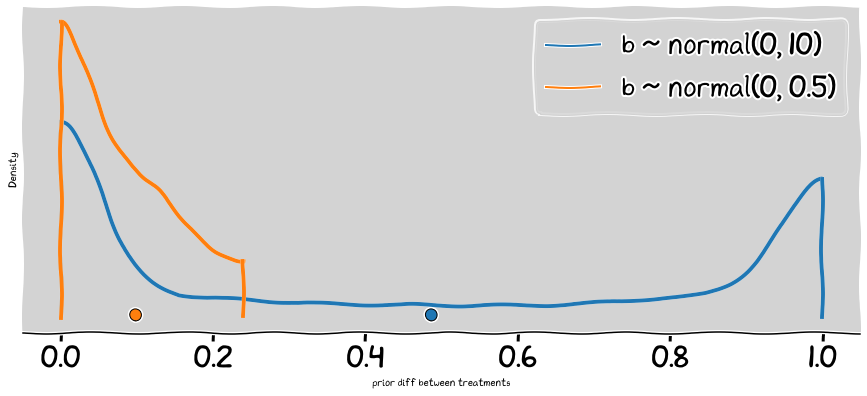

In [22]:
az.plot_density([
        np.absolute(p[0] - p[1]), 
        np.absolute(better_p[0] - better_p[1])
    ], 
    data_labels=['b ~ normal(0, 10)', 'b ~ normal(0, 0.5)'],
    figsize=(15, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

In [23]:
np.mean(np.absolute(better_p[0] - better_p[1]))

0.09791549449785536

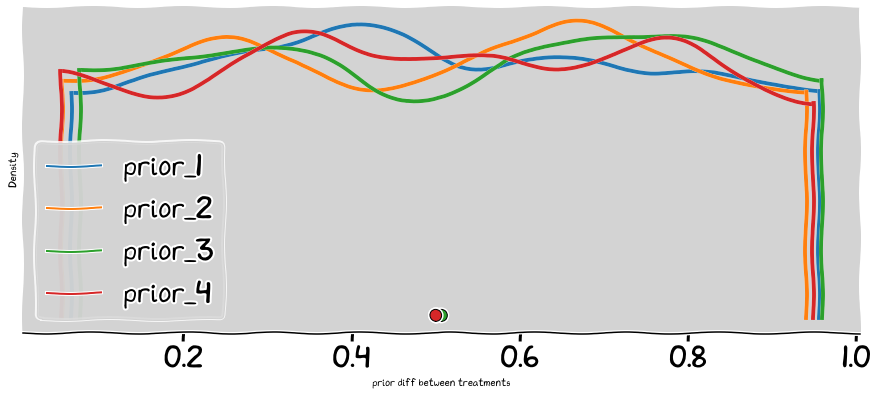

In [24]:
# Plot the 4 prior

az.plot_density([
        better_p[0], 
        better_p[1], 
        better_p[2], 
        better_p[3], 
    ],
    data_labels=['prior_1', 'prior_2', 'prior_3', 'prior_4'], 
    figsize=(15, 6))

plt.title('')
plt.xlabel('prior diff between treatments')
plt.ylabel('Density')

plt.show()

### R Code 11.10

In [25]:
data_list = df[['pulled_left', 'actor', 'treatment']].to_dict('list')
data_list['N'] = len(df)
data_list['qty_chimpanzees'] = len(df.actor.unique())
data_list['qty_treatment'] = len(df.treatment.unique())

data_list.keys()

dict_keys(['pulled_left', 'actor', 'treatment', 'N', 'qty_chimpanzees', 'qty_treatment'])

### R Code 11.11

In [26]:
model = """
    data {
        int N;
        int qty_chimpanzees;
        int qty_treatment;
        int pulled_left[N];
        int actor[N];
        int treatment[N];
    }
    
    parameters {
        vector[qty_chimpanzees] alpha;
        vector[qty_treatment] beta;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        beta ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori = stan.build(model, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 7, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_ddfihh48/model_ogtzmbou.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [27]:
samples_chimpanzees = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=['pulled_left', 'actor', 'treatment']
)

In [28]:
az.summary(samples_chimpanzees, var_names=['alpha', 'beta'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.461,0.323,-0.991,0.024,0.009,0.006,1360.0,2199.0,1.0
alpha[1],3.882,0.746,2.726,5.039,0.012,0.009,4391.0,2995.0,1.0
alpha[2],-0.755,0.327,-1.282,-0.228,0.009,0.006,1358.0,2188.0,1.0
alpha[3],-0.759,0.328,-1.278,-0.242,0.009,0.006,1428.0,2608.0,1.0
alpha[4],-0.456,0.327,-0.975,0.068,0.009,0.006,1360.0,2381.0,1.0
alpha[5],0.472,0.329,-0.060,0.985,0.009,0.006,1404.0,2413.0,1.0
alpha[6],1.951,0.412,1.325,2.640,0.009,0.006,2027.0,2927.0,1.0
beta[0],-0.034,0.277,-0.486,0.409,0.008,0.006,1162.0,2265.0,1.0
beta[1],0.486,0.282,0.037,0.932,0.008,0.006,1264.0,2021.0,1.0
beta[2],-0.375,0.283,-0.822,0.098,0.008,0.006,1273.0,2555.0,1.0


### R Code 11.12

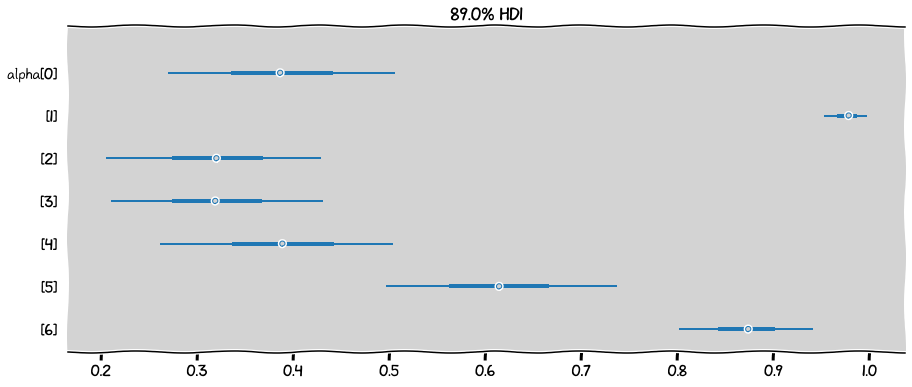

In [29]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['alpha'], 
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))

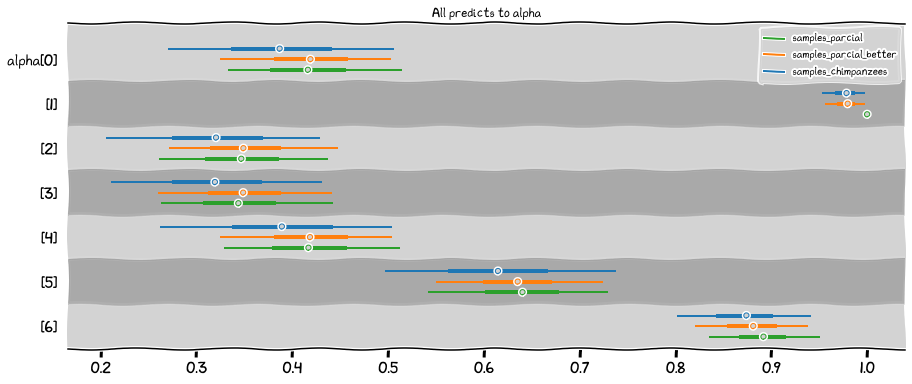

In [30]:
ax = az.plot_forest([samples_chimpanzees, samples_parcial_better, samples_partial], 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities,
                    model_names=['samples_chimpanzees', 'samples_parcial_better', 'samples_parcial'],
                    var_names=['alpha'], 
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))

plt.title('All predicts to alpha')

plt.show()

### R Code 11.13

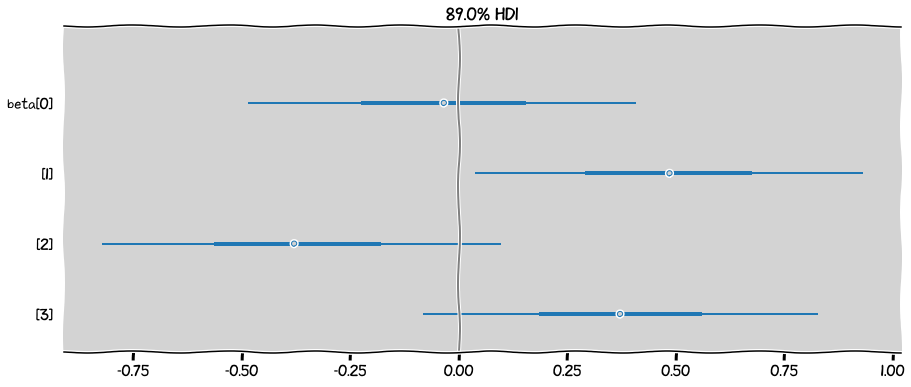

In [31]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['beta'], 
                    # transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(15, 6))
plt.axvline(x=0, c='gray')
plt.show()

### R Code 8.14

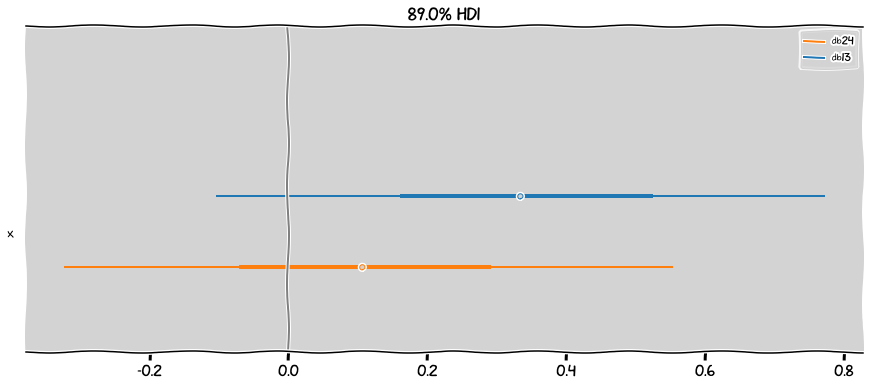

In [32]:
beta_0 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=0)
beta_1 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)
beta_2 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=2)
beta_3 = samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)

diff_beta_0_2 = az.extract(beta_0 - beta_2)
diff_beta_1_3 = az.extract(beta_1 - beta_3)

az.plot_forest(
    [diff_beta_0_2.beta.values, diff_beta_1_3.beta.values],
    combined=True,  # Joint all chains 
    kind="forestplot", # or ridgeplot to plot densities
    # transform=inv_logit,
    model_names=['db13', 'db24'],
    hdi_prob=0.89,
    figsize=(15, 6)
)

plt.axvline(x=0, c='gray')

plt.show()

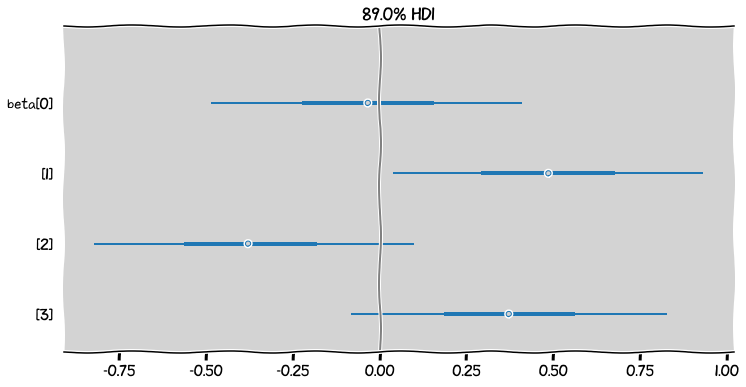

In [33]:
ax = az.plot_forest(samples_chimpanzees, 
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['beta'], 
                    # transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(12, 6))

plt.axvline(x=0, c='gray')
plt.show()

### R Code 11.15

In [34]:
pl = df.groupby(['actor', 'treatment'])[['actor', 'treatment', 'pulled_left']].mean(['pulled_left'])

pl.loc[pl.actor == 1]

actor  treatment  pulled_left
actor treatment                               
1     1            1.0        1.0     0.333333
      2            1.0        2.0     0.500000
      3            1.0        3.0     0.277778
      4            1.0        4.0     0.555556

### R Code 11.16 and R Code 11.17

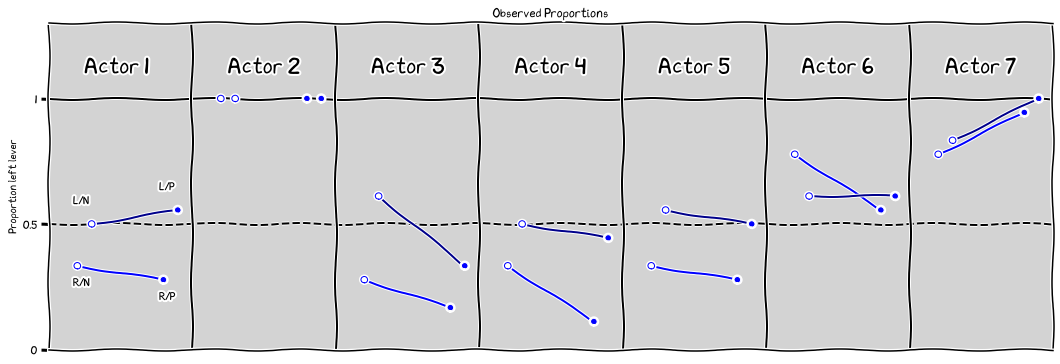

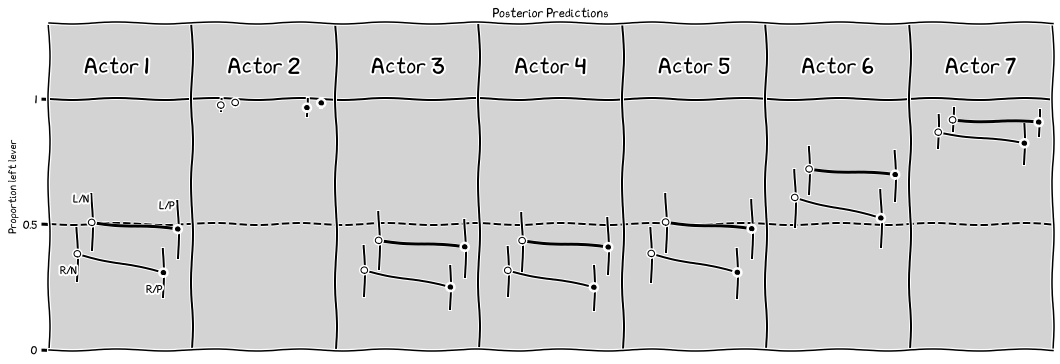

In [35]:
# R Code 11.16

plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 7)
plt.axhline(y=1, ls='-', c='black')
plt.axhline(y=0.5, ls='--', c='black')


for i in range(7):
    plt.axvline(x=i+1, c='black')
    plt.text(x=i + 0.25, y=1.1, s=f'Actor {i + 1}', size=20)
    
    RN, LN, RP, LP = pl.loc[pl.actor == i + 1, 'pulled_left'].values

    if not i == 1:
        plt.plot([0.2 + i, 0.8 + i], [RN, RP], color='blue')
    plt.plot(0.2 + i, RN, 'o', markerfacecolor='white', color='blue')
    plt.plot(0.8 + i, RP, 'o', markerfacecolor='blue', color='white')
    
    if not i == 1:
        plt.plot([0.3 + i, 0.9 + i], [LN, LP], color='darkblue')
    plt.plot(0.3 + i, LN, 'o', markerfacecolor='white', color='blue')
    plt.plot(0.9 + i, LP, 'o', markerfacecolor='blue', color='white')
    
    # Labels for only first points
    if i == 0:
        plt.text(x=0.17, y=RN - 0.08, s='R/N')
        plt.text(x=0.77, y=RP - 0.08, s='R/P')
        plt.text(x=0.17, y=LN + 0.08, s='L/N')
        plt.text(x=0.77, y=LP + 0.08, s='L/P')
    
plt.title('Observed Proportions')
plt.ylabel('Proportion left lever')
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([])

plt.show()


# R Code 11.17
# ============

plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 7)
plt.axhline(y=1, ls='-', c='black')
plt.axhline(y=0.5, ls='--', c='black')


for i in range(7):
    plt.axvline(x=i+1, c='black')
    plt.text(x=i + 0.25, y=1.1, s=f'Actor {i + 1}', size=20)
    
    alpha_chimp = az.extract(samples_chimpanzees.posterior.alpha.sel(alpha_dim_0=i)).alpha.values
    
    RN = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=0)).beta.values)
    LN = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)).beta.values)
    RP = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=2)).beta.values)
    LP = inv_logit(alpha_chimp + az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)).beta.values)
    
    # To R/N and R/P
    # ===============
    if not i == 1:
        plt.plot([0.2 + i, 0.8 + i], [RN.mean(), RP.mean()], color='black')
    
    # Plot hdi compatibility interval
    RN_hdi_min, RN_hdi_max = az.hdi(RN, hdi_prob=0.89)
    RP_hdi_min, RP_hdi_max = az.hdi(RP, hdi_prob=0.89)
    plt.plot([0.2 + i, 0.2 + i], [RN_hdi_min, RN_hdi_max], c='black')
    plt.plot([0.8 + i, 0.8 + i], [RP_hdi_min, RP_hdi_max], c='black')
    
    # Plot points
    plt.plot(0.2 + i, RN.mean(), 'o', markerfacecolor='white', color='black')
    plt.plot(0.8 + i, RP.mean(), 'o', markerfacecolor='black', color='white')
    
    # To L/N and L/P
    # ===============
    if not i == 1:
        plt.plot([0.3 + i, 0.9 + i], [LN.mean(), LP.mean()], color='black', linewidth=3)

    # Plot hdi compatibility interval
    LN_hdi_min, LN_hdi_max = az.hdi(LN, hdi_prob=0.89)
    LP_hdi_min, LP_hdi_max = az.hdi(LP, hdi_prob=0.89)
    plt.plot([0.3 + i, 0.3 + i], [LN_hdi_min, LN_hdi_max], c='black')
    plt.plot([0.9 + i, 0.9 + i], [LP_hdi_min, LP_hdi_max], c='black')

    plt.plot(0.3 + i, LN.mean(), 'o', markerfacecolor='white', color='black')
    plt.plot(0.9 + i, LP.mean(), 'o', markerfacecolor='black', color='white')
    
    # Labels for only first points
    if i == 0:
        plt.text(x=0.08, y=RN.mean() - 0.08, s='R/N')
        plt.text(x=0.68, y=RP.mean() - 0.08, s='R/P')
        plt.text(x=0.17, y=LN.mean() + 0.08, s='L/N')
        plt.text(x=0.77, y=LP.mean() + 0.08, s='L/P')
    
plt.title('Posterior Predictions')
plt.ylabel('Proportion left lever')
plt.yticks([0, 0.5, 1], [0, 0.5, 1])
plt.xticks([])

plt.show()

### R Code 11.18

In [36]:
df['side'] = df.prosoc_left + 1  # Right 1, Left 2  - Because R start index in 1
df['cond'] = df.condition + 1  # no partner 1, partner 2 - Because R start index in 1

### R Code 11.19

In [37]:
# Creating data list 2 to model
data_list2 = df[['pulled_left', 'actor', 'side', 'cond']].to_dict('list')
data_list2['N'] = len(df)
data_list2['qty_actors'] = len(df.actor.unique())
data_list2['qty_side'] = len(df.side.unique())
data_list2['qty_cond'] = len(df.cond.unique())

data_list2.keys()

dict_keys(['pulled_left', 'actor', 'side', 'cond', 'N', 'qty_actors', 'qty_side', 'qty_cond'])

In [38]:
model2 = """
    data {
        int N;
        int qty_actors;
        int qty_side;
        int qty_cond;
        
        int pulled_left[N];
        int actor[N];
        int side[N];
        int cond[N];
    }
    
    parameters {
        vector[qty_actors] alpha;
        vector[qty_side] bs;
        vector[qty_cond] bc;
    }
    
    model {
        vector[N] p;
        
        // Prioris
        alpha ~ normal(0, 1.5);
        bs ~ normal(0, 0.5);
        bc ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + bs[ side[i] ] + bc[ cond[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        // Likelihood
        pulled_left ~ binomial(1, p);
    }
"""

posteriori2 = stan.build(model2, data=data_list2)
samples2 = posteriori2.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_awah4qlb/model_2dwfndv7.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_awah4qlb/model_2dwfndv7.stan', line 9, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_awah4qlb/model_2dwfndv7.stan', line 10, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-forma

In [39]:
samples_chimpanzees_2 = az.from_pystan(
    posterior_model=posteriori2,
    posterior=samples2,
    observed_data=['pulled_left', 'actor', 'side', 'cond']
)

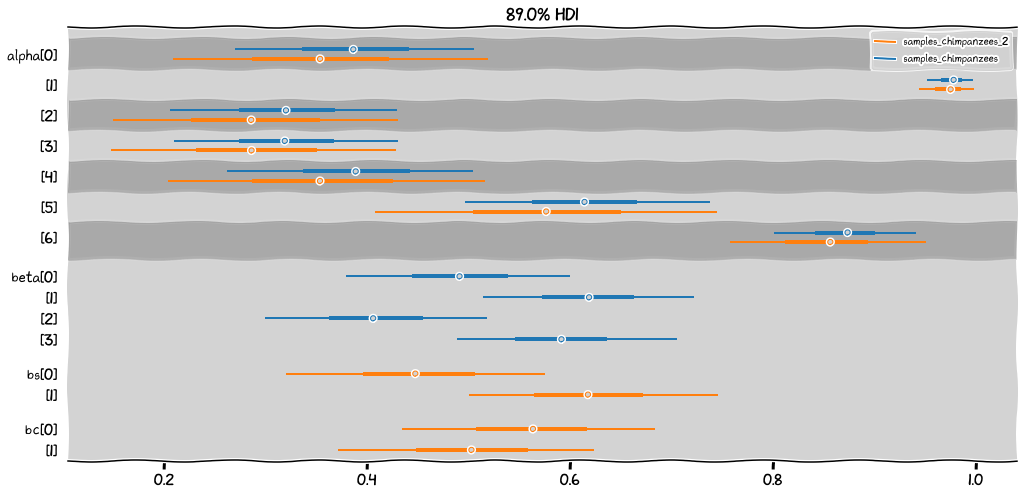

In [40]:
ax = az.plot_forest([samples_chimpanzees, samples_chimpanzees_2],
                    combined=True,  # Joint all chains 
                    kind="forestplot", # or ridgeplot to plot densities
                    var_names=['alpha', 'beta', 'bs', 'bc'], 
                    model_names=['samples_chimpanzees', 'samples_chimpanzees_2'],
                    transform=inv_logit,
                    hdi_prob=0.89,
                    figsize=(17, 8))
plt.show()

### R Code 11.21

To viewing data from rethinking packages

### R Code 11.22

Comparing two models

### R Code 11.23

In [41]:
beta_4 = az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=3)).beta.values
beta_2 = az.extract(samples_chimpanzees.posterior.beta.sel(beta_dim_0=1)).beta.values

np.mean( np.exp(beta_4 - beta_2) )

0.9311996671218865

### R Code 11.24

In [42]:
d = pd.read_csv('./data/chimpanzees.csv', sep=';')
d['treatment'] = 1 + d['prosoc_left'] + 2 * d['condition']
d['side'] = d['prosoc_left'] + 1  # right 1, left 2
d['cond'] = d['condition'] + 1  # no partner 1, partner 2

d_aggregate = d.groupby(['treatment', 'actor', 'side', 'cond'])[['pulled_left']].sum('pulled_left').copy()
d_aggregate.rename(columns={'pulled_left': 'left_pulls'}, inplace=True)  # Rename columns
d_aggregate.reset_index(inplace=True)
d_aggregate.head(8)

,treatment,actor,side,cond,left_pulls
0,1,1,1,1,6
1,1,2,1,1,18
2,1,3,1,1,5
3,1,4,1,1,6
4,1,5,1,1,6
5,1,6,1,1,14
6,1,7,1,1,14
7,2,1,2,1,9


In [43]:
len(d_aggregate)

28

### R Code 11.25

In [44]:
dat = d_aggregate[['left_pulls', 'treatment', 'actor', 'side', 'cond']].to_dict('list')
dat['N'] = len(d_aggregate)
dat['qty_actors'] = len(d_aggregate.actor.unique())
dat['qty_treatments'] = len(d_aggregate.treatment.unique())

dat.keys()

dict_keys(['left_pulls', 'treatment', 'actor', 'side', 'cond', 'N', 'qty_actors', 'qty_treatments'])

In [45]:
model = """
    data {
        int N;
        int qty_actors;
        int qty_treatments;
        
        int left_pulls[N];
        int actor[N];
        int treatment[N];
    }
    
    parameters {
        vector[qty_actors] alpha;
        vector[qty_treatments] beta;
    }
    
    model {
        vector[N] p;
        
        alpha ~ normal(0, 1.5);
        beta ~ normal(0, 0.5);
        
        for (i in 1:N){
            p[i] = alpha[ actor[i] ] + beta[ treatment[i] ];
            p[i] = inv_logit(p[i]);
        }
    
        left_pulls ~ binomial(18, p);
    }
"""

posteriori = stan.build(model, data=dat)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_tg7y7gna/model_3sv2or3b.stan', line 7, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_tg7y7gna/model_3sv2or3b.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_tg7y7gna/model_3sv2or3b.stan', line 9, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [46]:
model_chimp_bin = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=['left_pulls', 'treatment', 'actor'],
)

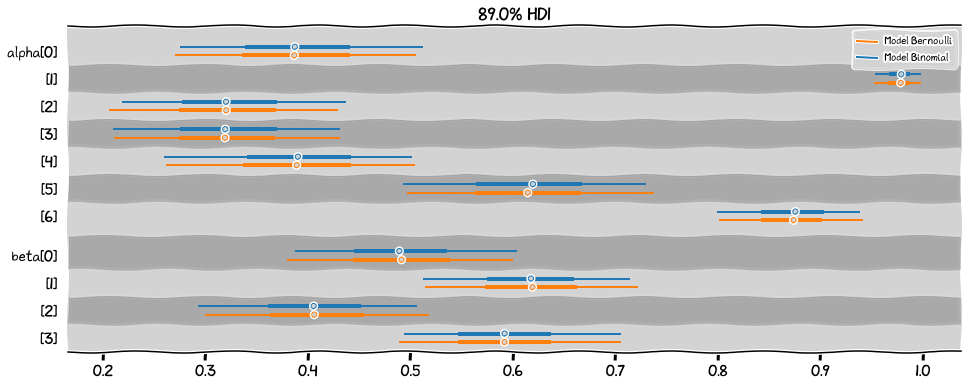

In [47]:
az.plot_forest(
    [model_chimp_bin, samples_chimpanzees],
    var_names=['alpha', 'beta'], 
    model_names=['Model Binomial', 'Model Bernoulli'],
    combined=True, 
    transform=inv_logit, 
    figsize=(16, 6),
    hdi_prob=0.89,
)

plt.show()

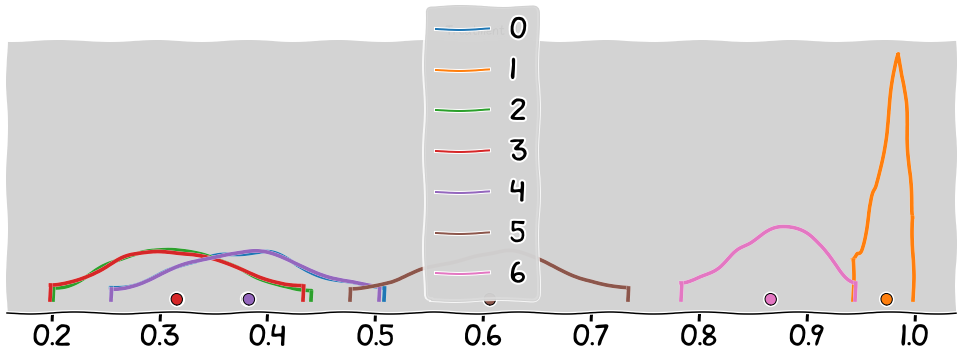

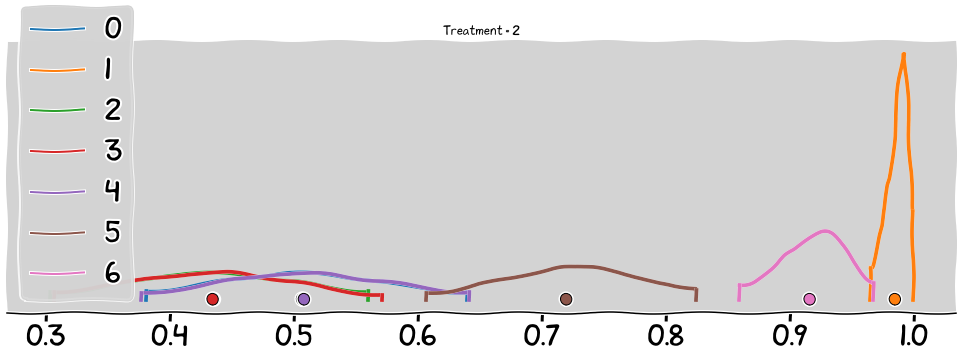

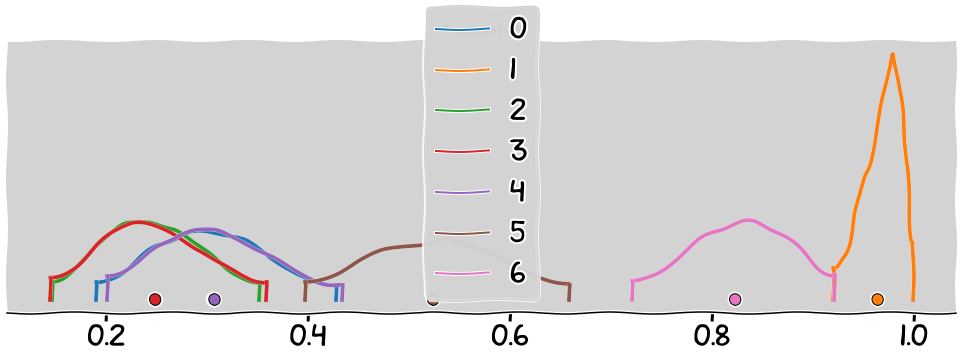

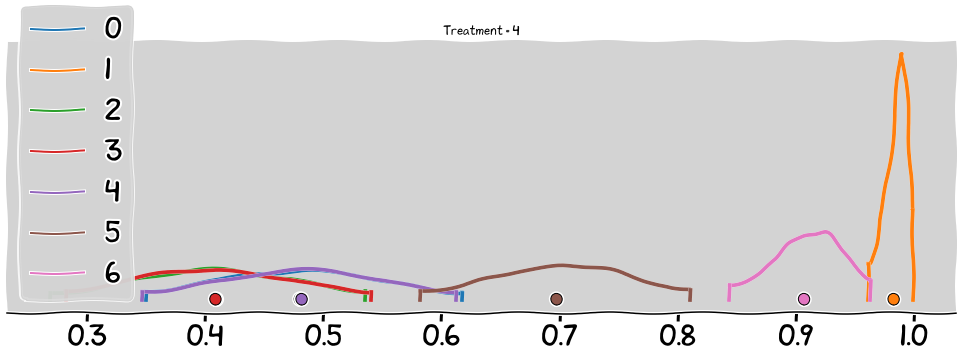

In [48]:
for t in range(4):
    p_chimp_bin = []
    for i in range(7):
        alpha_chimp_bin = model_chimp_bin.posterior.alpha.sel(alpha_dim_0=i).values.flatten()
        beta_chimp_bin = model_chimp_bin.posterior.beta.sel(beta_dim_0=t).values.flatten()

        p_chimp_bin.append(inv_logit(alpha_chimp_bin + beta_chimp_bin))

    az.plot_density(p_chimp_bin, figsize=(17, 5))
    plt.title(f'Treatment = {t + 1}')

plt.show()

### R Code 11.26

In [49]:
models_to_compare = {'model_chimp_bin': model_chimp_bin, 'samples_chimpanzees': samples_chimpanzees}

# az.compare(models_to_compare)  # or use 'elpd_waic' to WAIC

# XXX: Need to make posteriori in model to read in arviz

### R Code 11.27

In [50]:
# Deviance of aggregated 6-in-9
agg = -2 * np.log(stats.binom.pmf(k=6, n=9, p=0.2))
print(agg)

# Deviance of dis-aggregagted
k = [1, 1, 1, 1, 1, 1, 0, 0, 0]

not_agg = -2 * np.sum(np.log(stats.bernoulli.pmf(k=k, p=0.2)))
print(not_agg)

11.790482659407832
20.652116257094463


-----------

### My Tests

In [51]:
N = 100
p = np.random.rand()

y = np.random.binomial(1, p, N)

In [52]:
model = """
    data{
        int N;
        int y[N];
    }
    
    parameters {
        real alpha;
    }
    
    model {
        vector[N] p;
        
        // Priori
        alpha ~ normal(0.5, 1);
    
        for (i in 1:N){
                p[i] = inv_logit(alpha);
        }
    
        // Likelihood
        y ~ binomial(1, p);
    }
"""

data = {
    'N':N,
    'y': y,
}

posteriori = stan.build(model, data=data)
samples_test = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_74_5_884/model_xxtbv5ph.stan', line 4, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2.7e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.27 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 3.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition 

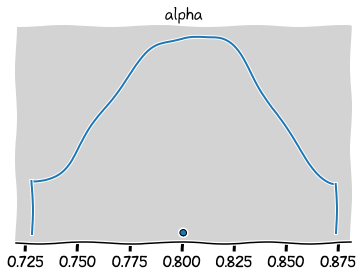

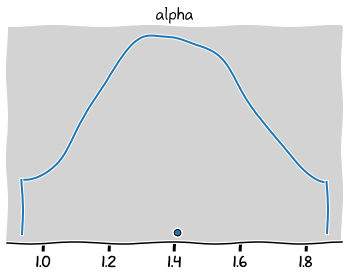

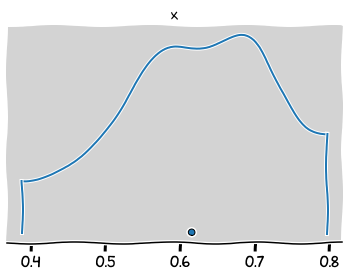

In [53]:
samples_test_az = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples_test,
    observed_data=['y']
)

az.plot_density(
    samples_test_az, var_names=['alpha'], 
    transform=inv_logit)

az.plot_density(
    samples_test_az, var_names=['alpha'])

az.plot_density(inv_logit(np.random.normal(0.5, 0.5, 1000)))  # Priori

plt.show()

In [54]:
print(p, np.mean(inv_logit(samples_test_az.posterior.alpha.values)))

0.7941189439897663 0.8007747891717577


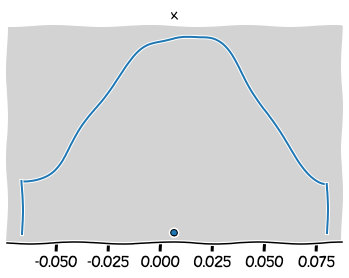

In [55]:
az.plot_density(inv_logit(samples_test_az.posterior.alpha.values) - p)
plt.show()

In [56]:
# Binomial

N = 100
p = np.random.rand()

y = np.random.binomial(5, p, N)

In [57]:
model = """
    data{
        int N;
        int y[N];
    }
    
    parameters {
        real alpha;
    }
    
    model {
        vector[N] p;
        
        // Priori
        alpha ~ normal(0.5, 1);
    
        for (i in 1:N){
                p[i] = inv_logit(alpha);
        }
    
        // Likelihood
        y ~ binomial(5, p);
    }
"""

data = {
    'N':N,
    'y': y,
}

posteriori = stan.build(model, data=data)
samples_test = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_yywp3af8/model_vjz4b4we.stan', line 4, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 2.8e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.28 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition wo

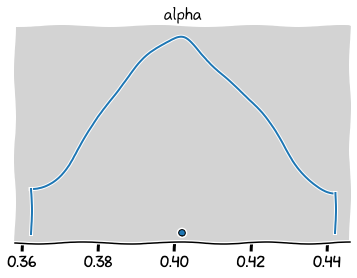

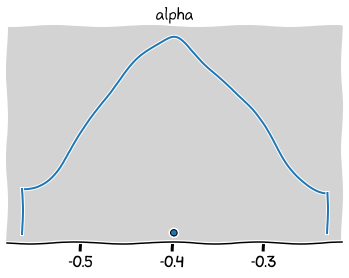

In [58]:
samples_test_az = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples_test,
    observed_data=['y']
)

az.plot_density(
    samples_test_az, var_names=['alpha'], 
    transform=inv_logit)

az.plot_density(
    samples_test_az, var_names=['alpha'])

plt.show()

In [59]:
print(p, np.mean(inv_logit(samples_test_az.posterior.alpha.values)))

0.41080051623086666 0.40200021269122577


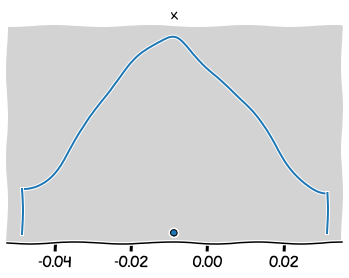

In [60]:
az.plot_density(inv_logit(samples_test_az.posterior.alpha.values) - p)
plt.show()

-----------

### R Code 11.28

In [61]:
df = pd.read_csv('./data/UCBadmit.csv', sep=';')
df

,dept,applicant.gender,admit,reject,applications
1,A,male,512,313,825
2,A,female,89,19,108
3,B,male,353,207,560
4,B,female,17,8,25
5,C,male,120,205,325
6,C,female,202,391,593
7,D,male,138,279,417
8,D,female,131,244,375
9,E,male,53,138,191
10,E,female,94,299,393


In [62]:
total_male_applic = df[df['applicant.gender']  == 'male']['applications'].sum()
total_male_admit = df[df['applicant.gender']  == 'male']['admit'].sum()
print('Percentual total male =', int(100*(total_male_admit / total_male_applic)), '%')

total_female_applic = df[df['applicant.gender']  == 'female']['applications'].sum()
total_female_admit = df[df['applicant.gender']  == 'female']['admit'].sum()
print('Percentual total female =', int(100*(total_female_admit / total_female_applic)), '%')

Percentual total male = 44 %
Percentual total female = 30 %


### R Code 11.29

$$ A_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{GID[i]} $$

$$ \alpha_j \sim Normal(0, 1.5) $$

In [63]:
df['gid'] = np.where(df['applicant.gender'] == 'male', 1, 2)

dat_list = df[['admit', 'applications', 'gid']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_genders'] = len(df.gid.unique())
dat_list

{'admit': [512, 89, 353, 17, 120, 202, 138, 131, 53, 94, 22, 24],
 'applications': [825, 108, 560, 25, 325, 593, 417, 375, 191, 393, 373, 341],
 'gid': [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
 'N': 12,
 'qty_genders': 2}

In [64]:
for dept_i in df.dept.unique():
    
    print(f'DEPARTMENT ---> {dept_i}')
        
    for gend_i in ['male', 'female']:
    
        applications = df[(df['dept'] == dept_i) & (df['applicant.gender'] == gend_i)]['applications']
        admit = df[(df['dept'] == dept_i) & (df['applicant.gender'] == gend_i)]['admit']
        perc_admit = admit.values / applications.values

        print(f'The dept {dept_i} has {int(100 * perc_admit[0])}% acceptions rate for {gend_i}')
        
    print('\n')


DEPARTMENT ---> A
The dept A has 62% acceptions rate for male
The dept A has 82% acceptions rate for female


DEPARTMENT ---> B
The dept B has 63% acceptions rate for male
The dept B has 68% acceptions rate for female


DEPARTMENT ---> C
The dept C has 36% acceptions rate for male
The dept C has 34% acceptions rate for female


DEPARTMENT ---> D
The dept D has 33% acceptions rate for male
The dept D has 34% acceptions rate for female


DEPARTMENT ---> E
The dept E has 27% acceptions rate for male
The dept E has 23% acceptions rate for female


DEPARTMENT ---> F
The dept F has 5% acceptions rate for male
The dept F has 7% acceptions rate for female




In [65]:
model = """
    data {
        int N;
        int qty_genders;
        
        int admit[N];
        int applications[N];
        int gid[N];
    }
    
    parameters {
        vector[qty_genders] alpha;
    }
    
    model {
        vector[N] p;
        
        alpha ~ normal(0, 1.5);
        
        for (i in 1:N){
            p[i] = alpha[ gid[i] ];
            p[i] = inv_logit(p[i]);
        }
        
        admit ~ binomial(applications, p);
    }
"""

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_71ga08vt/model_p5qihyrz.stan', line 6, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_71ga08vt/model_p5qihyrz.stan', line 7, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_71ga08vt/model_p5qihyrz.stan', line 8, column 8: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format

In [66]:
app_gender = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=list(dat_list.keys()),
    dims={
        'alpha': ['gender'],
    }
)

In [67]:
az.summary(app_gender)  # In scale inv-logit

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.220,0.038,-0.290,-0.147,0.001,0.000,3298.0,2491.0,1.0
alpha[1],-0.831,0.050,-0.927,-0.741,0.001,0.001,3304.0,2541.0,1.0


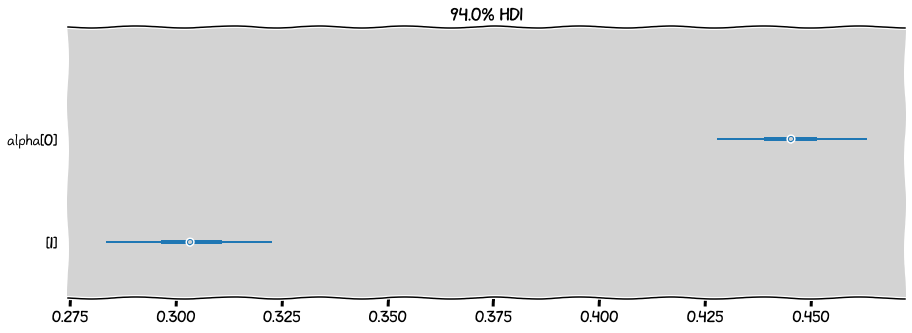

In [68]:
az.plot_forest(app_gender, var_names=['alpha'], combined=True, figsize=(15,5), transform=inv_logit)
plt.show()

### R Code 11.30

In [69]:
alpha_1 = app_gender.posterior.alpha.sel(gender=0)
alpha_2 = app_gender.posterior.alpha.sel(gender=1)

diff_a = alpha_1 - alpha_2
diff_p = inv_logit(alpha_1) - inv_logit(alpha_2)

az.summary(diff_a)  # Shark

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.61,0.063,0.497,0.731,0.001,0.001,3266.0,2446.0,1.0


In [70]:
az.summary(diff_p)  # Deer

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.142,0.014,0.115,0.168,0.0,0.0,3282.0,2509.0,1.0


### R Code 11.31

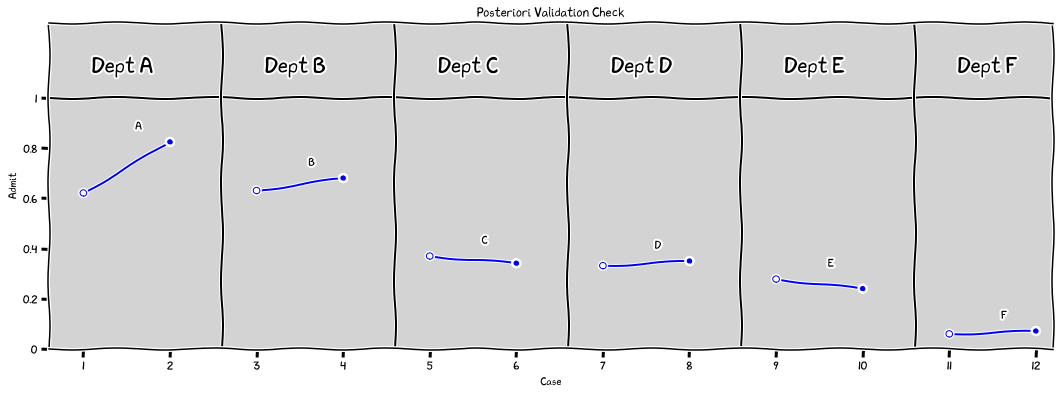

In [71]:
plt.figure(figsize=(18, 6))

plt.ylim(0, 1.3)
plt.xlim(0, 5.8)
plt.axhline(y=1, ls='-', c='black')

depts = df.dept.unique()

for i in range(6):
    plt.axvline(x=i+1, c='black')
    
    dept = depts[i]

    plt.text(x=i + 0.25, y=1.1, s=f'Dept {dept}', size=20)

    perc_male, perc_female = df.loc[df['dept'] == dept, 'admit'] / df.loc[df['dept'] == dept, 'applications']

    plt.plot([0.2 + i, 0.7 + i], [perc_male, perc_female], color='blue')  # Line
    plt.plot(0.2 + i, perc_male, 'o', markerfacecolor='white', color='blue')  # point male
    plt.plot(0.7 + i, perc_female, 'o', markerfacecolor='blue', color='white')  # point female
    
    plt.text(x=0.5 + i, y=max(perc_male, perc_female) + 0.05, s=dept)
    
plt.title('Posteriori Validation Check')
plt.ylabel('Admit')
plt.xlabel('Case')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], [0, 0.2, 0.4, 0.6, 0.8, 1])
plt.xticks(np.arange(0, 5.9, 0.5) + 0.2, np.arange(1, 12.1, 1, dtype=int))

plt.show()

# Need put points with open points from samples

### R Code 11.32

We want ask:

    - What is the average difference in probability of admission between women and man within departments?

$$ A_i \sim Binomial(N_i, p_i) $$

$$ logit(p_i) = \alpha_{GID[i]} + \delta_{DEPT[i]} $$

$$ \alpha_j \sim Normal(0, 1.5) $$

$$ \delta_k \sim Normal(0, 1.5) $$

In [72]:
df['gid'] = np.where(df['applicant.gender'] == 'male', 1, 2)

df['dept_idx'] = [ord(dept_i) - 64 for dept_i in df['dept']]  # ord('A') = 65

dat_list = df[['admit', 'applications', 'gid', 'dept_idx']].to_dict('list')
dat_list['N'] = len(df)
dat_list['qty_genders'] = len(df.gid.unique())
dat_list['qty_dept'] = len(df.dept_idx.unique())

dat_list

{'admit': [512, 89, 353, 17, 120, 202, 138, 131, 53, 94, 22, 24],
 'applications': [825, 108, 560, 25, 325, 593, 417, 375, 191, 393, 373, 341],
 'gid': [1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2],
 'dept_idx': [1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6],
 'N': 12,
 'qty_genders': 2,
 'qty_dept': 6}

In [73]:
model = """
    data {
        int N;
        int qty_genders;
        int qty_dept;
        
        array[N] int admit;
        array[N] int applications;
        array[N] int gid;
        array[N] int dept_idx;
    }
    
    parameters {
        vector[qty_genders] alpha;
        vector[ qty_dept ] delta;
    }
    
    model {
        vector[N] p;
        
        alpha ~ normal(0, 1.5);
        delta ~ normal(0, 1.5);
        
        for (i in 1:N){
            p[i] = alpha[ gid[i] ] + delta[ dept_idx[i] ];  # O Delta calcula a taxa média de admissão para o departamento i
            p[i] = inv_logit(p[i]);
        }
        
        admit ~ binomial(applications, p);
    }
"""

posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_ctkdznui/model_5ccid6b7.stan', line 25, column 60: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 9e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.09 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.5e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.15 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.4e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.14 seconds.
  Adjust your expectati

In [74]:
applic_gender_2 = az.from_pystan(
    posterior_model=posteriori,
    posterior=samples,
    observed_data=list(dat_list.keys()),
    dims = {
        'alpha': ['gender'],
        'delta': ['department'],
    }
)

In [75]:
az.summary(applic_gender_2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.543,0.558,-1.475,0.600,0.033,0.028,302.0,252.0,1.01
alpha[1],-0.447,0.559,-1.477,0.588,0.033,0.028,302.0,264.0,1.01
delta[0],1.124,0.560,0.048,2.103,0.033,0.026,302.0,246.0,1.01
delta[1],1.078,0.562,-0.028,2.038,0.033,0.026,304.0,272.0,1.01
delta[2],-0.136,0.560,-1.180,0.879,0.033,0.025,304.0,262.0,1.01
delta[3],-0.171,0.560,-1.197,0.870,0.033,0.025,304.0,263.0,1.01
delta[4],-0.611,0.564,-1.707,0.376,0.033,0.024,302.0,261.0,1.01
delta[5],-2.165,0.572,-3.233,-1.113,0.033,0.023,322.0,283.0,1.01


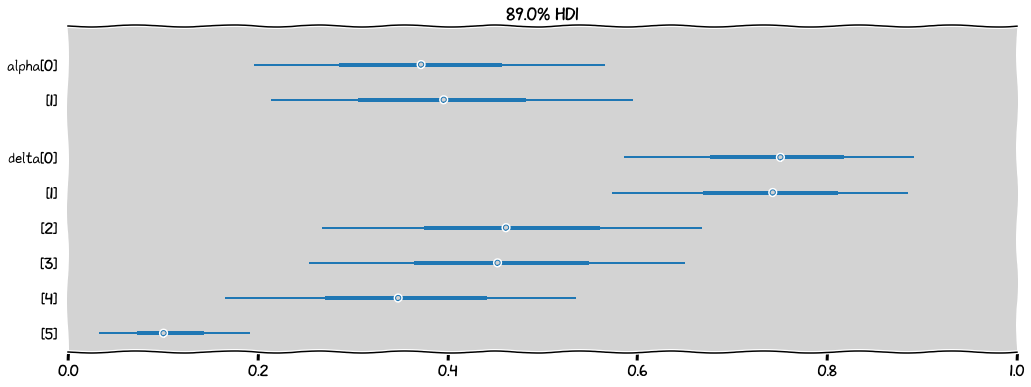

In [76]:
az.plot_forest(
    applic_gender_2,
    var_names=['alpha', 'delta'],
    combined=True,
    transform=inv_logit,
    figsize=(17, 6),
    hdi_prob=0.89,
)

plt.xlim((0, 1))
plt.show()

### R Code 11.33

In [77]:
alpha_male = applic_gender_2.posterior.alpha.sel(gender=0)
alpha_female = applic_gender_2.posterior.alpha.sel(gender=1)

az.summary(alpha_male - alpha_female, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.097,0.081,-0.221,0.036,0.001,0.001,4860.0,3542.0,1.0


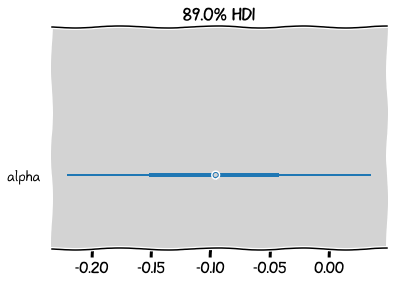

In [78]:
az.plot_forest((alpha_male - alpha_female), hdi_prob=0.89, combined=True)
plt.show()

In [79]:
az.summary(inv_logit(alpha_male) - inv_logit(alpha_female), hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.022,0.018,-0.05,0.008,0.0,0.0,3577.0,3438.0,1.0


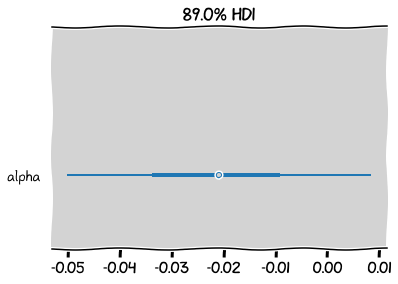

In [80]:
az.plot_forest((inv_logit(alpha_male) - inv_logit(alpha_female)), hdi_prob=0.89, combined=True)
plt.show()

In [81]:
pg = {}
pg['male'] = {}
pg['female'] = {}

dept_i = 'A'

for dept_i in df['dept'].unique():

    total = df[df['dept'] == dept_i]['applications'].sum()
    total_male = df[(df['dept'] == dept_i) & (df['applicant.gender'] == 'male')]['applications'].sum()
    total_female = df[(df['dept'] == dept_i) & (df['applicant.gender'] == 'female')]['applications'].sum()

    pg['male'][dept_i] = round(total_male / total, 2)
    pg['female'][dept_i] = round(total_female / total, 2)
    
pd.DataFrame.from_dict(pg).T

,A,B,C,D,E,F
male,0.88,0.96,0.35,0.53,0.33,0.52
female,0.12,0.04,0.65,0.47,0.67,0.48


## Poisson Regression

### R Code 11.35

In [82]:
N = 10000
p = 1/1000

y = np.random.binomial(N, p, 10000)
print(f'The mean is {np.mean(y)} and variance is {np.var(y)}')

The mean is 9.968 and variance is 10.042176


### R Code 11.36

In [83]:
df = pd.read_csv('./data/Kline.csv', sep=';')
df

,culture,population,contact,total_tools,mean_TU
0,Malekula,1100,low,13,3.2
1,Tikopia,1500,low,22,4.7
2,Santa Cruz,3600,low,24,4.0
3,Yap,4791,high,43,5.0
4,Lau Fiji,7400,high,33,5.0
5,Trobriand,8000,high,19,4.0
6,Chuuk,9200,high,40,3.8
7,Manus,13000,low,28,6.6
8,Tonga,17500,high,55,5.4
9,Hawaii,275000,low,71,6.6


$$ y_i \sim Poisson(\lambda) $$

The parameter $\lambda$ is expected value of the outcome y.

The *link function* for poisson is the $log$ link.

$$ y_i \sim Poisson(\lambda_i) $$

$$ log(\lambda_i) = \alpha + \beta(x_i - \bar x) $$

### R Code 11.37

In [183]:
df['log_population'] = np.log(df['population'])  # log population
df['P'] = df['log_population'] - np.mean(df['log_population']) / np.std(df['log_population'])  #std log population
df['contact_id'] = [2 if contact_i == 'high' else 1 for contact_i in df['contact'].values ]  # CID 1:low; 2:high
df

,culture,population,contact,total_tools,mean_TU,log_population,P,contact_id
0,Malekula,1100,low,13,3.2,7.003065,0.812051,1
1,Tikopia,1500,low,22,4.7,7.313220,1.122206,1
2,Santa Cruz,3600,low,24,4.0,8.188689,1.997674,1
3,Yap,4791,high,43,5.0,8.474494,2.283480,2
4,Lau Fiji,7400,high,33,5.0,8.909235,2.718220,2
5,Trobriand,8000,high,19,4.0,8.987197,2.796182,2
6,Chuuk,9200,high,40,3.8,9.126959,2.935944,2
7,Manus,13000,low,28,6.6,9.472705,3.281690,1
8,Tonga,17500,high,55,5.4,9.769956,3.578941,2
9,Hawaii,275000,low,71,6.6,12.524526,6.333512,1


#### Model - Poisson Regression

$$ T_i \sim Poisson(\lambda_i) $$

$$ log(\lambda_i) = \alpha_{CID[i]} + \beta_{CID[i]} log(P_i) $$

$$ \alpha_j \sim \mbox{to be determined} $$
$$ \beta_j \sim \mbox{to be determined} $$


-----

$$ T_i \sim Poisson(\lambda_i) $$

$$ log(\lambda_i) = \alpha$$

$$ \alpha \sim Normal(0, 10) $$


### R Code 11.38

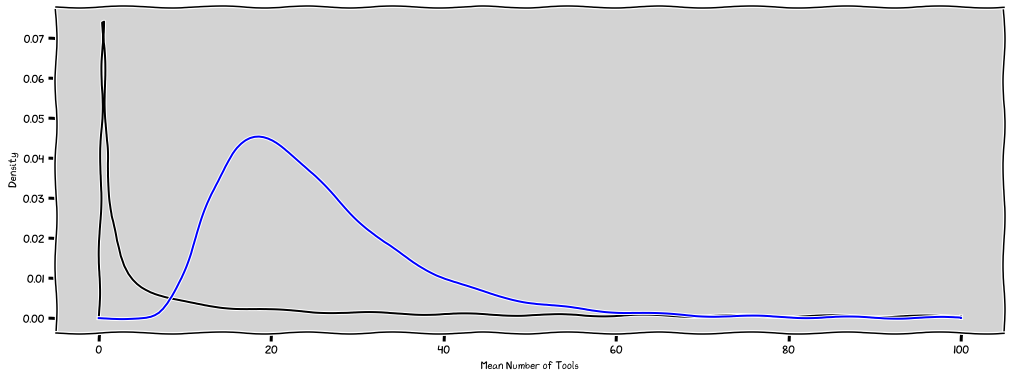

In [85]:
plt.figure(figsize=(17, 6))

N = 200
x = np.linspace(0, 100, N)

y = stats.lognorm.pdf(x=x, s=10, loc=0, scale=20)  # See the docs to understanding the parameters

# R Code 11.40
y_new = stats.lognorm.pdf(x=x, s=0.5, loc=3, scale=20)  # See the docs to understanding the parameters

plt.plot(x, y, c='black')
plt.plot(x, y_new, c='blue')

plt.ylabel('Density')
plt.xlabel('Mean Number of Tools')

plt.show()

### R Code 11.39

In [86]:
a = np.random.normal(0, 10, 1000)
lambda_ = np.exp(a)
np.mean(lambda_)

9583004840.24319

### R Code 11.40

In [87]:
# Ploted in R Code 11.38

### R Code 11.41

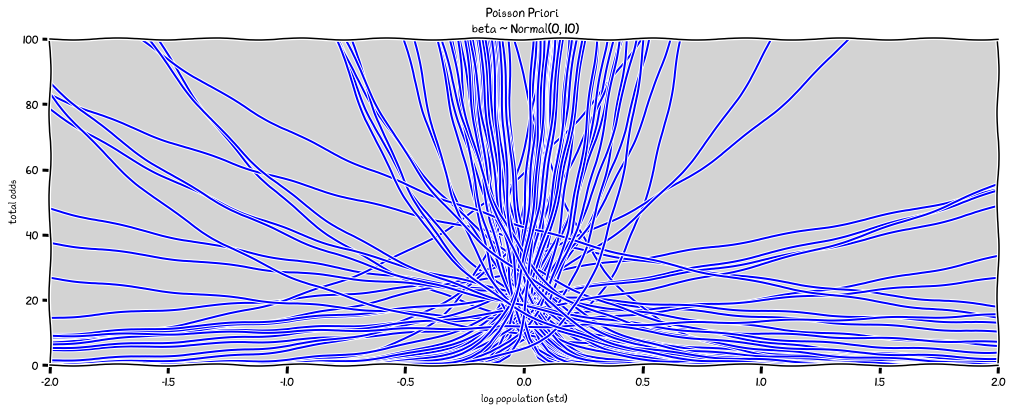

In [88]:
N = 100
a = np.random.normal(3, 0.5, N)  # prior to alpha
b = np.random.normal(0, 10, N)  # prior to beta

x = np.linspace(-2, 2, 100)

prioris = []

plt.figure(figsize=(17, 6))

for i in range(N):
    plt.plot(x, np.exp(a[i] + b[i] * x), c='blue')
    
plt.xlim(-2, 2)
plt.ylim(0, 100)

plt.title('Poisson Priori \n beta ~ Normal(0, 10)')
plt.xlabel('log population (std)')
plt.ylabel('total odds')
    
plt.show()

### R Code 11.42

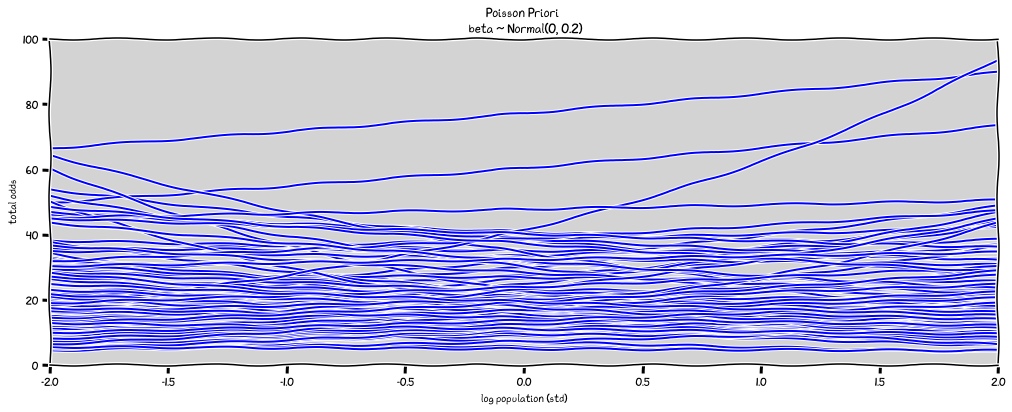

In [89]:
N = 100
a = np.random.normal(3, 0.5, N)  # prior to alpha
b = np.random.normal(0, 0.2, N)  # prior to beta

x = np.linspace(-2, 2, 100)

prioris = []

plt.figure(figsize=(17, 6))
for i in range(N):
    plt.plot(x, np.exp(a[i] + b[i] * x), c='blue')
    
plt.xlim(-2, 2)
plt.ylim(0, 100)

plt.title('Poisson Priori \n beta ~ Normal(0, 0.2)')
plt.xlabel('log population (std)')
plt.ylabel('total odds')

plt.show()

### R Code 11.43

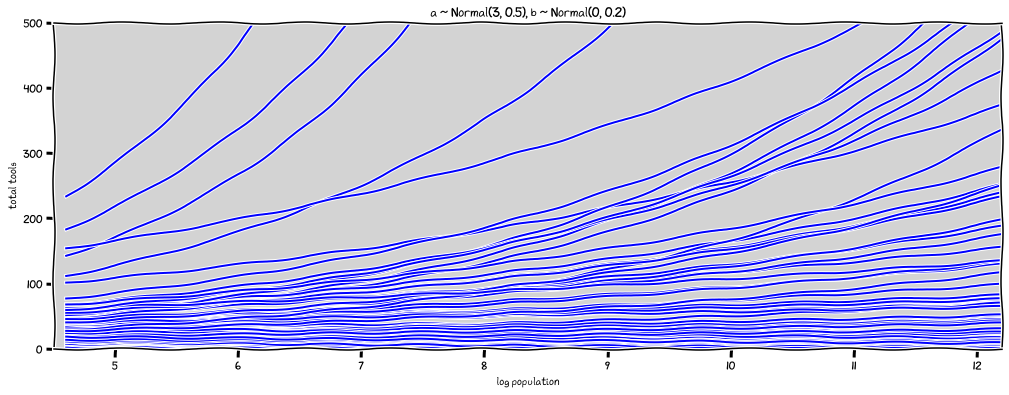

In [90]:
N = 100
a = np.random.normal(3, 0.5, N)  # prior to alpha
b = np.random.normal(0, 0.2, N)  # prior to beta

x_seq = np.linspace(np.log(100), np.log(200000), 100)  # log(population)

lambda_poisson =  [ np.exp(a[i] + b[i] * x_seq) for i in range(N) ]

plt.figure(figsize=(17,6))

for i in range(N):
    plt.plot(x_seq, lambda_poisson[i], c='blue')

plt.ylim(0, 500)
plt.xlim(min(x_seq) - 0.1, max(x_seq))

plt.title('a ~ Normal(3, 0.5), b ~ Normal(0, 0.2)')
plt.xlabel('log population')
plt.ylabel('total tools')

plt.show()

### R Code 11.44

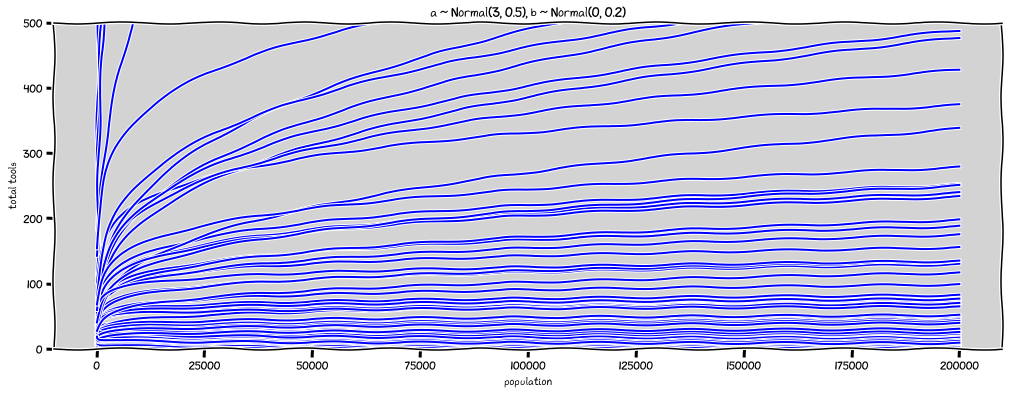

In [91]:
#N = 100
#a = np.random.normal(3, 0.5, N)  # prior to alpha
#b = np.random.normal(0, 0.2, N)  # prior to beta

x_seq = np.linspace(np.log(100), np.log(200000), 100)  # log(population)

lambda_poisson_ =  [ np.exp(a[i] + b[i] * x_seq) for i in range(N) ]

plt.figure(figsize=(17,6))

for i in range(N):
    plt.plot(np.exp(x_seq), lambda_poisson_[i], c='blue')

plt.ylim(0, 500)
#plt.xlim(min(np.exp(x_seq)), max(np.exp(x_seq)))

plt.title('a ~ Normal(3, 0.5), b ~ Normal(0, 0.2)')
plt.xlabel('population')
plt.ylabel('total tools')

plt.show()

#### Curiosidade do python

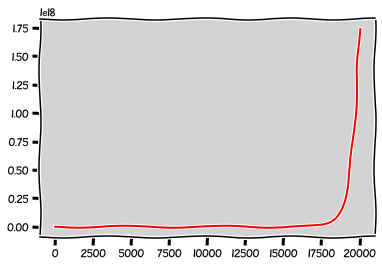

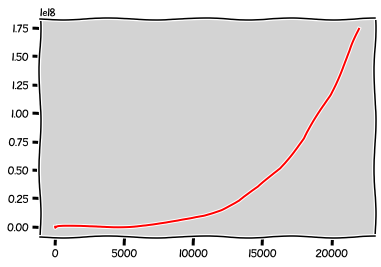

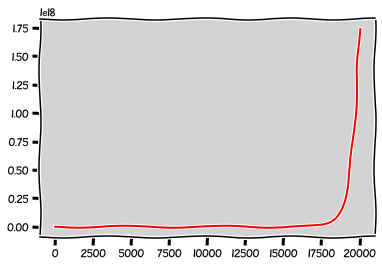

In [92]:
x = np.linspace(0, 10, 100)
y = np.exp(2 + 4 * x)

plt.plot(x*2000, y, c='red')
plt.show()

plt.plot(np.exp(x), y, c='red')
plt.show()

plt.plot(x*2000, y, c='red')
plt.show()

### R Code 11.45

#### Model:

$$ T_i \sim Poisson(\lambda_i) $$

$$ log(\lambda_i) = \alpha_{CID[i]} $$

$$ \alpha_j \sim Normal(3, 0.5) $$


In [93]:
model_11_9 = """
    data {
        int N;
        array[N] int total_tools;
    }
    
    parameters {
        real alpha;
    }
    
    model {
        // Priori
        alpha ~ normal(3, 0.5);
        
        // Likelihood
        total_tools ~ poisson(exp(alpha));
    }
"""

data_list = df[['total_tools']].to_dict('list')
data_list['N'] = len(df)

posteriori = stan.build(model_11_9, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 3e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.03 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.02 seconds.
  Adjust your expectations accordingly!


In [94]:
model_11_9_post = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=list(data_list.keys()),
)

In [95]:
az.summary(model_11_9_post, var_names=['alpha'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,3.541,0.052,3.443,3.639,0.001,0.001,1661.0,1639.0,1.0


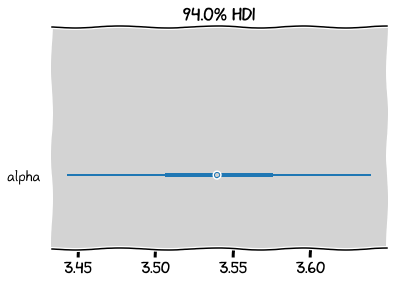

In [96]:
az.plot_forest(model_11_9_post, var_names=['alpha'], combined=True)
plt.show()

#### Model:

$$ T_i \sim Poisson(\lambda_i) $$

$$ log(\lambda_i) = \alpha_{CID[i]} + \beta_{CID[i]} \times log(P_i) $$

$$ \alpha_j \sim Normal(3, 0.5) $$

$$ \beta_j \sim Normal(0, 0.2) $$

In [97]:
model_11_9_new = """
    data {
        int N;
        int qty_cid;
        array[N] int total_tools;
        array[N] real log_population;
        array[N] int contact_id;
    }
    
    parameters {
        array[qty_cid] real alpha;
        array[qty_cid] real beta;
    }
    
    model {
        vector[N] lambda;
        
        // Priori
        alpha ~ normal(3, 0.5);
        beta ~ normal(0, 0.2);
        
        // Likelihood
        for(i in 1:N){
                lambda[i] = alpha[ contact_id[i] ] + beta[ contact_id[i] ];
                lambda[i] = exp(lambda[i]);
        }
        total_tools ~ poisson(lambda);
    }
"""

data_list = df[['total_tools', 'log_population', 'contact_id']].to_dict('list')
data_list['N'] = len(df)
data_list['qty_cid'] = len(df.contact_id.unique())

posteriori = stan.build(model_11_9_new, data=data_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 5e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.05 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 4e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.04 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1.1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.11 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!


In [98]:
model_11_9_new_post = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=list(data_list.keys()),
    dims={
        'alpha': ['contact_id'],
        'beta': ['contact_id'],
    }
)

In [99]:
az.summary(model_11_9_new_post)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],3.379,0.195,2.991,3.740,0.005,0.003,1661.0,1591.0,1.0
alpha[1],3.543,0.201,3.189,3.950,0.005,0.004,1541.0,1423.0,1.0
beta[0],0.061,0.182,-0.290,0.412,0.004,0.004,1679.0,1602.0,1.0
beta[1],0.082,0.188,-0.276,0.429,0.005,0.004,1508.0,1530.0,1.0


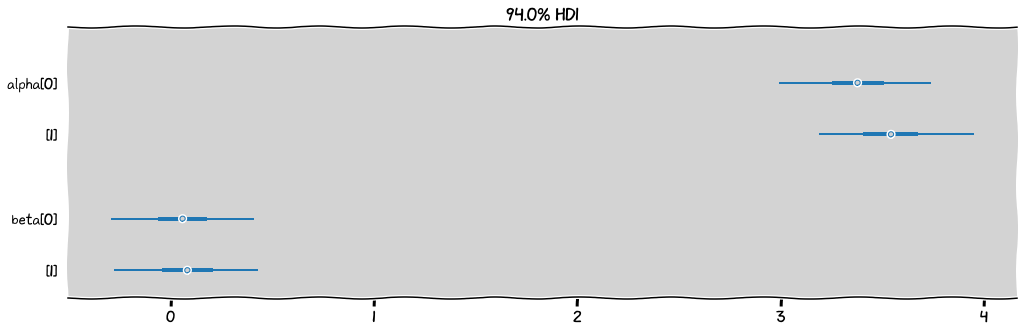

In [102]:
az.plot_forest(model_11_9_new_post, var_names=['alpha', 'beta'], combined=True, figsize=(17, 5))
plt.show()

### R Code 11.46

In [108]:
# Need to make a generated_quantities to compute compare


dict_to_compare = {
    'model_11_9_post': model_11_9_post,
    'model_11_9_new_post': model_11_9_new_post
}

# az.compare(dict_to_compare)

### R Code 11.47

In [221]:
# TODO:  Tem calcular a posteriori prediction da Poisson e não apenas 

print(lambda_poisson)
print(np.random.poisson(lambda_poisson))

[30.84871268 30.95398941 31.05962541 31.16562192 31.27198016 31.37870136
 31.48578677 31.59323763 31.70105518 31.80924068 31.91779538 32.02672055
 32.13601744 32.24568732 32.35573148 32.46615118 32.5769477  32.68812234
 32.79967638 32.91161112 33.02392786 33.1366279  33.24971255 33.36318312
 33.47704092 33.59128729 33.70592354 33.82095101 33.93637104 34.05218495
 34.1683941  34.28499983 34.4020035  34.51940647 34.63721009 34.75541575
 34.87402479 34.99303862 35.1124586  35.23228612 35.35252257 35.47316936
 35.59422787 35.71569951 35.8375857  35.95988785 36.08260737 36.2057457
 36.32930426 36.45328448 36.57768781 36.70251569 36.82776956 36.95345089
 37.07956113 37.20610173 37.33307419 37.46047995 37.58832052 37.71659736
 37.84531197 37.97446584 38.10406047 38.23409737 38.36457804 38.49550399
 38.62687676 38.75869786 38.89096882 39.02369118 39.15686648 39.29049627
 39.42458209 39.5591255  39.69412806 39.82959135 39.96551693 40.10190637
 40.23876127 40.37608322 40.5138738  40.65213461 40.

3.379490686339395
0.06108527403572016


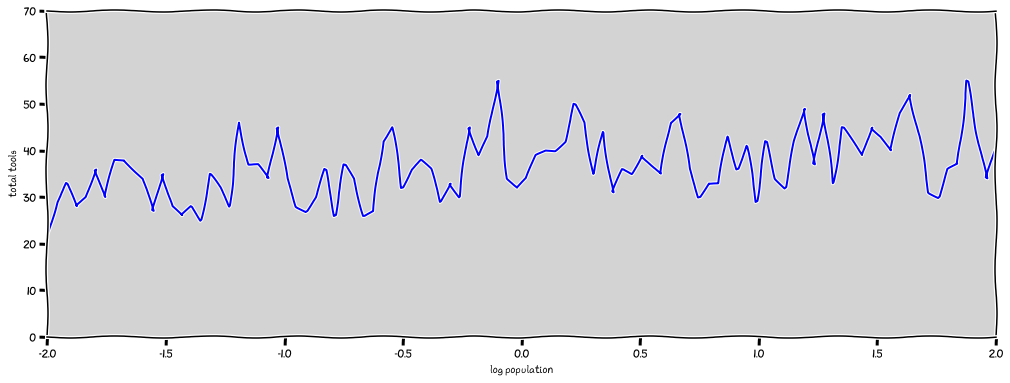

In [222]:
N = 100

a_low = model_11_9_new_post.posterior.alpha.sel(contact_id=0).values.flatten()  # CID = 0 (low contact) 
b_low = model_11_9_new_post.posterior.beta.sel(contact_id=0).values.flatten()  # CID = 0 (low contact)

print(np.mean(a_low))
print(np.mean(b_low))

x_seq = np.linspace(df.P.min(), df.P.max(), 100)  # log(population)

lambda_poisson =  np.exp(np.mean(a_low) + np.mean(b_low) * x_seq)

plt.figure(figsize=(17,6))

plt.plot(np.linspace(-2, 2, 100), np.random.poisson(lambda_poisson), c='blue')

plt.ylim(0, 70)
plt.xlim(-2, 2)

plt.title('')
plt.xlabel('log population')
plt.ylabel('total tools')

plt.show()

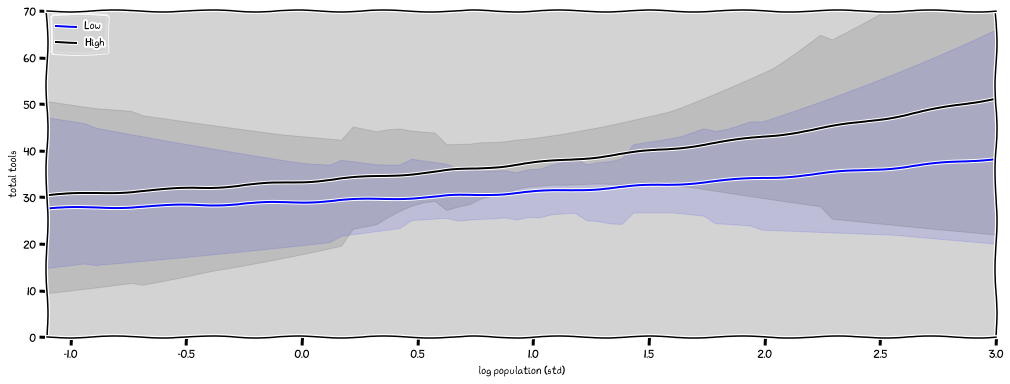

In [172]:
N = 100
a_low = model_11_9_new_post.posterior.alpha.sel(contact_id=0).values.flatten()  # CID = 0 (low contact) 
b_low = model_11_9_new_post.posterior.beta.sel(contact_id=0).values.flatten()  # CID = 0 (low contact)

a_high = model_11_9_new_post.posterior.alpha.sel(contact_id=1).values.flatten()  # CID = 1 (high contact) 
b_high = model_11_9_new_post.posterior.beta.sel(contact_id=1).values.flatten()  # CID = 1 (high contact)

x_seq = np.linspace(-1.4, 3, 100)  # log(population)

lambda_poisson_low =  [ np.exp(a_low[i] + b_low[i] * x_seq) for i in range(N) ]
hdi_low = np.transpose([az.hdi(np.transpose(lambda_poisson_low)[i]) for i in range(len(lambda_poisson_low))])

lambda_poisson_high =  [ np.exp(a_high[i] + b_high[i] * x_seq) for i in range(N) ]
hdi_high = np.transpose([az.hdi(np.transpose(lambda_poisson_high)[i]) for i in range(len(lambda_poisson_high))])

plt.figure(figsize=(17,6))

plt.plot(x_seq, np.mean(lambda_poisson_low, axis=0), c='blue', label='Low')  # Low
plt.fill_between(x_seq, hdi_low[0], hdi_low[1], color='blue', alpha=0.1)

plt.plot(x_seq, np.mean(lambda_poisson_high, axis=0), c='black', label='High')  # High
plt.fill_between(x_seq, hdi_high[0], hdi_high[1], color='black', alpha=0.1)

plt.ylim(0, 70)
plt.xlim(min(x_seq + 1) - 0.1, max(x_seq))

plt.title('')
plt.xlabel('log population (std)')
plt.ylabel('total tools')
plt.legend(loc='upper left')


plt.show()

### R Code 11.48

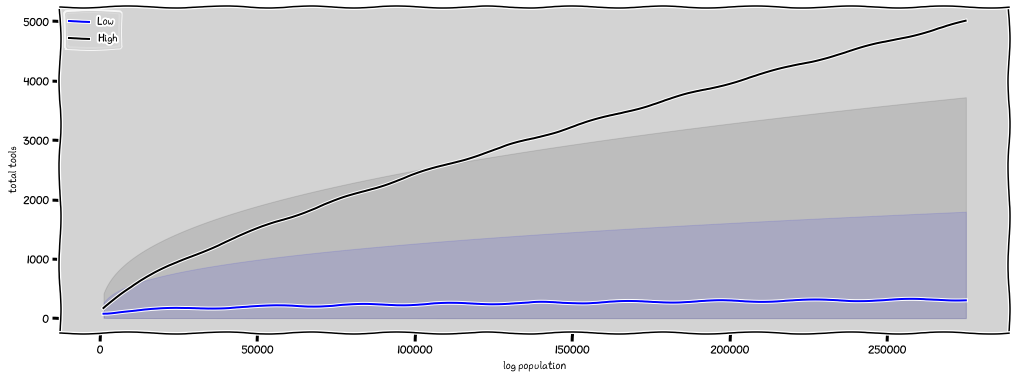

In [182]:
N = 100
a_low = model_11_9_new_post.posterior.alpha.sel(contact_id=0).values.flatten()  # CID = 0 (low contact) 
b_low = model_11_9_new_post.posterior.beta.sel(contact_id=0).values.flatten()  # CID = 0 (low contact)

a_high = model_11_9_new_post.posterior.alpha.sel(contact_id=1).values.flatten()  # CID = 1 (high contact) 
b_high = model_11_9_new_post.posterior.beta.sel(contact_id=1).values.flatten()  # CID = 1 (high contact)

x_seq = np.linspace(df.log_population.min(), df.log_population.max(), 100)  # log(population)

lambda_poisson_low =  [ np.exp(a_low[i] + b_low[i] * x_seq) for i in range(N) ]
hdi_low = np.transpose([az.hdi(np.transpose(lambda_poisson_low)[i]) for i in range(len(lambda_poisson_low))])

lambda_poisson_high =  [ np.exp(a_high[i] + b_high[i] * x_seq) for i in range(N) ]
hdi_high = np.transpose([az.hdi(np.transpose(lambda_poisson_high)[i]) for i in range(len(lambda_poisson_high))])

plt.figure(figsize=(17,6))

plt.plot(np.exp(x_seq), np.mean(lambda_poisson_low, axis=0), c='blue', label='Low')  # Low
plt.fill_between(np.exp(x_seq), hdi_low[0], hdi_low[1], color='blue', alpha=0.1)

plt.plot(np.exp(x_seq), np.mean(lambda_poisson_high, axis=0), c='black', label='High')  # High
plt.fill_between(np.exp(x_seq), hdi_high[0], hdi_high[1], color='black', alpha=0.1)

#plt.ylim(0, 70)
#plt.xlim(min(x_seq + 1) - 0.1, max(x_seq))

plt.title('')
plt.xlabel('log population')
plt.ylabel('total tools')
plt.legend(loc='upper left')


plt.show()